# Exact and noisy simulation with Qiskit Aer primitives

[Exact simulation with Qiskit primitives](simulate-with-qiskit-primitives) demonstrates how to use the reference primitives included with Qiskit to perform exact simulation of quantum circuits. Currently existing quantum processors suffer from errors, or noise, so the results of an exact simulation do not necessarily reflect the results you would expect when running circuits on real hardware. While the reference primitives in Qiskit do not support modeling noise, [Qiskit Aer](https://qiskit.org/ecosystem/aer/) includes implementations of the primitives that do support modeling noise. Qiskit Aer is a high-performance quantum circuit simulator that you can use in place of the reference primitives for better performance and more features. It is part of the [Qiskit Ecosystem](https://qiskit.github.io/ecosystem/). In this article, we demonstrate the use of Qiskit Aer primitives for exact and noisy simulation.

<Admonition>
  The Qiskit Aer primitives do not yet support the V2 interface.  To use the Aer simulator with V2 primitives, use the [Qiskit Runtime local testing mode](local-testing-mode) instead.
</Admonition>

Let's create an example circuit on eight qubits.


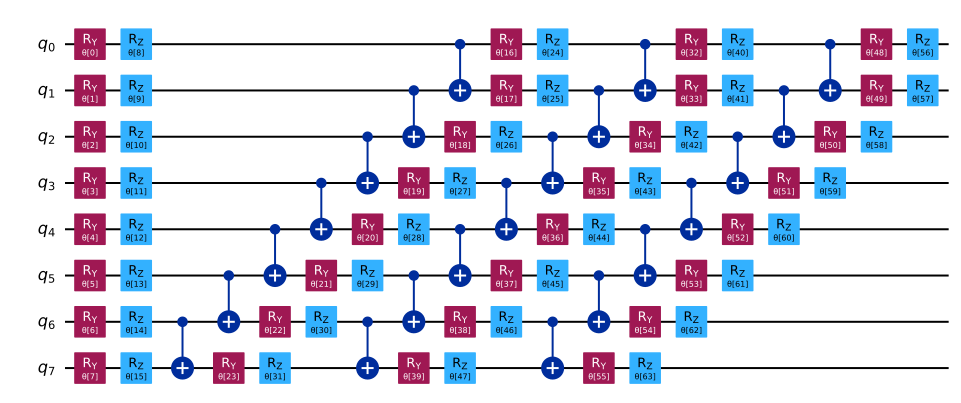

In [1]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 8
circuit = EfficientSU2(n_qubits)
circuit.decompose().draw("mpl")

This circuit contains parameters to represent the rotation angles for $R_y$ and $R_z$ gates. When simulating this circuit, we need to specify explicit values for these parameters. In the next cell, we specify some values for these parameters and use the [Estimator](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.primitives.Estimator.html) primitive from Qiskit Aer to compute the exact expectation value of the observable $ZZ \cdots Z$.


In [2]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator

observable = SparsePauliOp("Z" * n_qubits)
params = [0.1] * circuit.num_parameters

exact_estimator = Estimator()
job = exact_estimator.run(circuit, observable, params)
exact_value = job.result().values[0]
exact_value

0.875

Now, let's initialize a noise model that includes depolarizing error of 2% on every CX gate. In practice, the error arising from the two-qubit gates, which are CX gates here, are the dominant source of error when running a circuit. See [Build noise models](./building_noise_models) for an overview of constructing noise models in Qiskit Aer.

In the next cell, we construct an Estimator that incorporates this noise model and use it to compute the expectation value of the observable.


In [3]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)

noisy_estimator = Estimator(
    backend_options={"noise_model": noise_model}
)
job = noisy_estimator.run(circuit, observable, params)
noisy_value = job.result().values[0]
noisy_value

0.740234375

As you can see, the expectation value in the presence of the noise is quite far from the correct value. In practice, you can employ a variety of error mitigation techniques to counter the effects of the noise, but a discussion of these techniques is outside the scope of this article.

To get a very rough sense of how the noise affects the final result, consider our noise model, which adds a depolarizing error of 2% to each CX gate. Depolarizing error with probability $p$ is defined as a quantum channel $E$ that has the following action on a density matrix $\rho$:

$$

E(\rho) = (1 - p) \rho + p\frac{I}{2^n}

$$

where $n$ is the number of qubits, in this case, 2. That is, with probability $p$, the state is replaced with the completely mixed state, and the state is preserved with probability $1 - p$. After $m$ applications of the depolarizing channel, the probability of the state being preserved would be $(1 - p)^m$. Therefore, we expect the probability of retaining the correct state at the end of the simulation to go down exponentially with the number of CX gates in our circuit.

Let's count the number of CX gates in our circuit and compute $(1 - p)^m$. Because our circuit uses the EfficientSU2 class, we'll need to call `decompose` once to decompose it into CX gates. We call `count_ops` to get a dictionary that maps gate names to counts, and retrieve the entry for the CX gate.


In [4]:
cx_count = circuit.decompose().count_ops()["cx"]
(1 - cx_depolarizing_prob) ** cx_count

0.6542558123199923

This value, 65%, gives a rough estimate of the probability that our final state is correct. It is a conservative estimate because it does not take into account the initial state of the simulation. To get a more concrete estimate of how much our final state deviates from the correct state, let's use the [Sampler](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.primitives.Sampler.html) primitive to estimate the final measurement probability distributions with and without noise, and then compute the fidelity between these distributions. When running the Sampler, we pass `shots=None` to request a final distribution that does not include random sampling error.


In [5]:
import math
from qiskit.result import ProbDistribution
from qiskit_aer.primitives import Sampler


measured_circuit = circuit.copy()
measured_circuit.measure_all()

# Get exact probability distribution
exact_sampler = Sampler()
job = exact_sampler.run(measured_circuit, params, shots=None)
exact_quasis = job.result().quasi_dists[0]
exact_probs = exact_quasis.nearest_probability_distribution()

# Get noisy probability distribution
noisy_sampler = Sampler(backend_options={"noise_model": noise_model})
job = noisy_sampler.run(measured_circuit, params, shots=None)
noisy_quasis = job.result().quasi_dists[0]
noisy_probs = noisy_quasis.nearest_probability_distribution()


# Compute fidelity
def fidelity(dist1: ProbDistribution, dist2: ProbDistribution) -> float:
    result = 0
    for bitstring in dist1 | dist2:
        prob1 = dist1.get(bitstring, 0)
        prob2 = dist2.get(bitstring, 0)
        result += math.sqrt(prob1 * prob2)
    return result**2


fidelity(exact_probs, noisy_probs)

0.8917750028756636

## Next steps

<Admonition type="tip" title="Recommendations">
  *   To simulate small, simple circuits, see [Exact simulation with Qiskit primitives](simulate-with-qiskit-primitives).

  *   Review the [Qiskit Aer](https://qiskit.org/ecosystem/aer/) documentation.

  *   Learn how to run on a physical system in the [Run](../run) section.
</Admonition>
